# 2.Stochastic Gradient Descent (SGD)

## 2.1. SGD Classifier

판다스 데이터프레임을 생성합니다.

In [1]:
import pandas as pd

fish = pd.read_csv('https://bit.ly/fish_csv_data')

Species 열을 제외한 나머지 5개를 입력 데이터로 사용합니다.

In [2]:
fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()
fish_target = fish['Species'].to_numpy()

데이터를 훈련 세트와 테스트 세트로 나눕니다.

In [3]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

훈련 세트와 테스트 세트의 특성을 표준화 전처리합니다.

In [4]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

scikit-learn에서 확률적 경사 하강법을 제공하는 대표적인 분류용 class는 **SGDClassifier**입니다.

In [5]:
from sklearn.linear_model import SGDClassifier

SGDClassifier의 객체를 만들 때, 2개의 매개변수를 지정합니다.

loss = 손실 함수의 종류 지정
max_iter = 수행할 에포크 횟수 지정

In [6]:
sc = SGDClassifier(loss='log', max_iter=10, random_state=42)
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.773109243697479
0.775


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


출력된 훈련 세트와 테스트 세트 정확도가 낮습니다.

확률적 경사 하강법은 점진적 학습이 가능합니다. 훈련한 모델 sc를 추가로 더 훈련해 봅시다.

모델을 이어서 훈련할 때는 **partial_fit()** method를 사용합니다. 이 method는 fit() method와 사용법이 같지만 호출할 때마다 1 에포크씩 이어서 훈련할 수 있습니다.

In [7]:
sc.partial_fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8151260504201681
0.85


아직 점수가 낮긴 하지만, 에포크를 한 번 더 실행하니 정확도가 향상되었습니다.

이 모델을 여러 에포크에서 더 훈련해 볼 필요가 있는데, 얼마나 훈련을 더 해야할 지에 대한 기준이 필요해 보입니다.

## 2.2.Epoch and Overfitting/Underfitting

확률적 경사 하강법을 사용한 모델은 에포크 횟수에 따라 underfitting이나 overfitting이 될 수 있습니다.

적은 에포크 횟수 동안에 훈련한 모델은 훈련 세트를 덜 학습하여 underfitting된 모델일 가능성이 높습니다.

반대로, 많은 에포크 횟수 동안에 훈련한 모델은 훈련 세트에 너무 잘 맞아, 테스트 세트에는 오히려 점수가 나쁜 overfitting된 모델일 가능성이 높습니다.

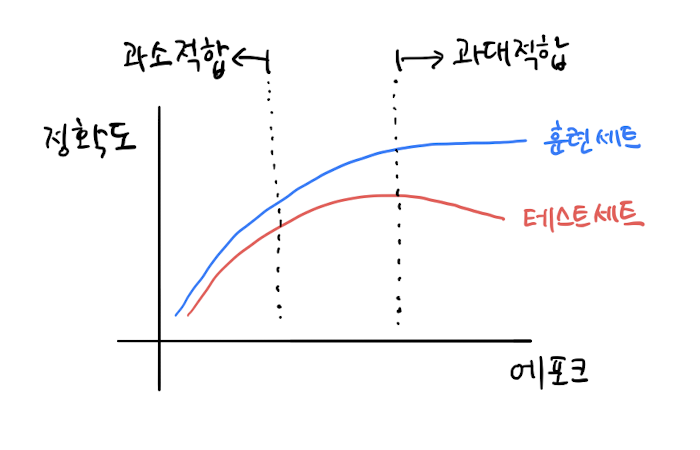

위 그래프와 같이, 훈련 세트 점수는 에포크가 진행될수록 꾸준히 증가하지만, 테스트 세트 점수는 어느 순간 감소합니다. 이 지점이 이 모델이 overfitting되기 시작하는 곳입니다.

여기서는 partial_fit() method만 사용할 건데, 그럴려면 훈련 세트에 있는 전체 클래스의 레이블을 partial_fit() method에 전달해 주어야 합니다.

In [8]:
import numpy as np

sc = SGDClassifier(loss='log_loss', random_state=42)

train_score = []
test_score = []

classes = np.unique(train_target)

300번의 에포크 동안 훈련을 반복하여 진행해 보겠습니다.

In [9]:
for _ in range(0, 300):
    sc.partial_fit(train_scaled, train_target, classes=classes) # `partial_fit` : single epoch
    
    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

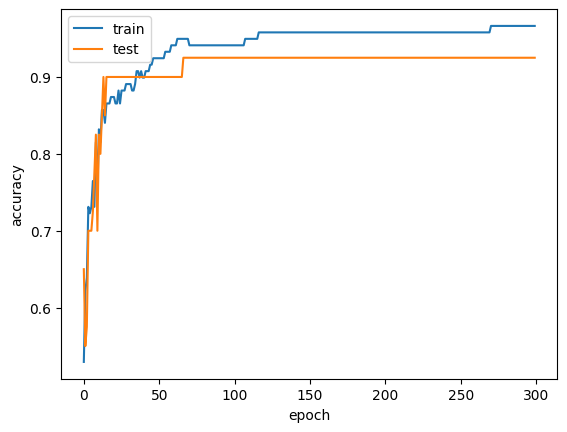

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_score, label="train")
plt.plot(test_score, label="test")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

백 번째 에포크 이후에는 훈련 세트와 테스트 세트의 점수가 조금씩 벌어지고 있습니다. 또한, 에포크 초기에는 과소적합되어 훈련 세트와 테스트 세트의 점수가 낮습니다.

SGDClassifier의 반복 횟수를 100에 맞추고 모델을 다시 훈련해 보겠습니다.

In [11]:
sc = SGDClassifier(loss='log_loss', max_iter=100, tol=None, random_state=42)
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.957983193277311
0.925


SGDClassifier는 일정 에포크 동안 성능이 향상되지 않으면 더 훈련하지 않고 자동으로 멈춥니다.

`tol` 매개변수는 향상될 최솟값을 지정합니다.

SGDClassifier의 loss 매개변수에 대해 잠시 살펴보면, loss 매개변수의 기본값은 `hinge`입니다.

**Hinge loss**는 **support vector machine(SVM)**이라 불리는 손실 함수입니다.

In [12]:
sc = SGDClassifier(loss='hinge', max_iter=100, tol=None, random_state=42)
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.9495798319327731
0.925


# 3.Feature Engineering and Regularization

## 3.1. Data Prepration

지난 시간에는 하나의 특성을 사용해 선형 회귀(linear regression)을 훈련시켰습니다.

이번 시간에는 여러 개의 특성을 사용할 건데, 이처럼 여러 개의 특성을 사용한 선형 회귀를 **다중 회귀(multiple regression)**라고 부릅니다.

이 예제에서는 *농어의 길이뿐만 아니라 농어의 깊이와 두께*도 함께 사용합니다. 또한 3개의 특성을 각각 제곱하여 추가하고 각 특성을 서로 곱해서 또 다른 특성을 만듭니다.

이렇게 기존의 특성을 사용해 새로운 특성을 뽑아내는 작업을 **특성 공학(feature engineering)**이라고 부릅니다.

In [13]:
import pandas as pd

In [14]:
df = pd.read_csv('https://bit.ly/perch_csv_data')
perch_full = df.to_numpy()
print(perch_full)

[[ 8.4   2.11  1.41]
 [13.7   3.53  2.  ]
 [15.    3.82  2.43]
 [16.2   4.59  2.63]
 [17.4   4.59  2.94]
 [18.    5.22  3.32]
 [18.7   5.2   3.12]
 [19.    5.64  3.05]
 [19.6   5.14  3.04]
 [20.    5.08  2.77]
 [21.    5.69  3.56]
 [21.    5.92  3.31]
 [21.    5.69  3.67]
 [21.3   6.38  3.53]
 [22.    6.11  3.41]
 [22.    5.64  3.52]
 [22.    6.11  3.52]
 [22.    5.88  3.52]
 [22.    5.52  4.  ]
 [22.5   5.86  3.62]
 [22.5   6.79  3.62]
 [22.7   5.95  3.63]
 [23.    5.22  3.63]
 [23.5   6.28  3.72]
 [24.    7.29  3.72]
 [24.    6.38  3.82]
 [24.6   6.73  4.17]
 [25.    6.44  3.68]
 [25.6   6.56  4.24]
 [26.5   7.17  4.14]
 [27.3   8.32  5.14]
 [27.5   7.17  4.34]
 [27.5   7.05  4.34]
 [27.5   7.28  4.57]
 [28.    7.82  4.2 ]
 [28.7   7.59  4.64]
 [30.    7.62  4.77]
 [32.8  10.03  6.02]
 [34.5  10.26  6.39]
 [35.   11.49  7.8 ]
 [36.5  10.88  6.86]
 [36.   10.61  6.74]
 [37.   10.84  6.26]
 [37.   10.57  6.37]
 [39.   11.14  7.49]
 [39.   11.14  6.  ]
 [39.   12.43  7.35]
 [40.   11.93

In [15]:
# target data
import numpy as np

perch_weight = np.array(
    [5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 
     110.0, 115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 
     130.0, 150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 
     197.0, 218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 
     514.0, 556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 
     820.0, 850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 
     1000.0, 1000.0]
     )

perch_full과 perch_weight를 훈련 세트와 테스트 세트로 나눕니다.

In [16]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(perch_full, perch_weight, random_state=42)

## 3.2. Transformer of Scikit-learn

scikit-learn은 특성을 만들거나 전처리하기 위한 다양한 클래스를 제공합니다. 이런 클래스를 **변환기(transformer)**라고 부릅니다.


In [17]:
from sklearn.preprocessing import PolynomialFeatures

2개의 특성으로, 2와 3으로 이루어진 샘플 하나를 적용하겠습니다.

**fit()** method는 새롭게 만들 특성 조합을 찾고 **transform()** method는 실제로 데이터를 변환합니다. 

In [18]:
poly = PolynomialFeatures()
poly.fit([[2, 3]])
print(poly.transform([[2, 3]]))

[[1. 2. 3. 4. 6. 9.]]


2개의 특성(원소)을 가진 샘플 [2,3]이 6개의 특성을 가진 샘플로 바뀌었습니다.

In [19]:
poly = PolynomialFeatures(include_bias=False)
poly.fit([[2, 3]])
print(poly.transform([[2, 3]]))

[[2. 3. 4. 6. 9.]]


절편을 위한 항이 제거되고 특성의 제곱과 특성끼리 곱한 항만 추가되었습니다.

이제 이 방식으로 train_input에 적용하겠습니다.

In [20]:
poly = PolynomialFeatures(include_bias=False)

poly.fit(train_input)
train_poly = poly.transform(train_input)

In [21]:
print(train_poly.shape)

(42, 9)


PolynomialFeatures class는 **get_feature_names()** method를 호출하면 9개의 특성이 각각 어떤 입력의 조합으로 만들어졌는지 알려 줍니다.

In [22]:
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

'x0'은 첫 번째 특성을 의미하고, 'x0^2'는 첫 번째 특성의 제곱, 'x0 x1'은 첫 번째 특성과 두 번째 특성의 곱을 나타내는 식입니다.

이제 테스트 세트를 변환하겠습니다.

In [23]:
test_poly = poly.transform(test_input)

## 3.3. Training Multiple Regression Model

scikit-learn의 LinearRegression class를 import하고 앞에서 만든 train_poly를 사용해 모델을 훈련시켜 보겠습니다.

In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))

0.9903183436982124


In [25]:
print(lr.score(test_poly, test_target))

0.9714559911594122


테스트 세트에 대한 점수는 높아지지 않았지만, 농어의 길이만 사용했을 때 있던 underfitting 문제는 더 이상 나타나지 않습니다.

특성을 더 추가하여, 5제곱 항까지 특성을 만들어 출력해 보겠습니다.

In [26]:
poly = PolynomialFeatures(degree=5, include_bias=True)

poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

In [27]:
print(train_poly.shape)

(42, 56)


In [28]:
poly.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2',
       'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3', 'x0^4', 'x0^3 x1',
       'x0^3 x2', 'x0^2 x1^2', 'x0^2 x1 x2', 'x0^2 x2^2', 'x0 x1^3',
       'x0 x1^2 x2', 'x0 x1 x2^2', 'x0 x2^3', 'x1^4', 'x1^3 x2',
       'x1^2 x2^2', 'x1 x2^3', 'x2^4', 'x0^5', 'x0^4 x1', 'x0^4 x2',
       'x0^3 x1^2', 'x0^3 x1 x2', 'x0^3 x2^2', 'x0^2 x1^3',
       'x0^2 x1^2 x2', 'x0^2 x1 x2^2', 'x0^2 x2^3', 'x0 x1^4',
       'x0 x1^3 x2', 'x0 x1^2 x2^2', 'x0 x1 x2^3', 'x0 x2^4', 'x1^5',
       'x1^4 x2', 'x1^3 x2^2', 'x1^2 x2^3', 'x1 x2^4', 'x2^5'],
      dtype=object)

train_poly 배열의 열의 개수가 특성의 개수입니다. 이 데이터를 사용해 선형 회귀 모델을 다시 훈련하겠습니다.

In [29]:
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))

0.9999999999999999


In [30]:
print(lr.score(test_poly, test_target))

-144.40489673037428


훈련 세트에 대한 점수는 거의 완벽하지만, 테스트 세트에 대한 점수는 아주 큰 음수입니다.

특성의 개수를 크게 늘리면 선형 모델은 훈련 세트에 대해 거의 완벽하게 학습할 수 있습니다. 하지만 이런 모델은 너무 overfitting되므로 테스트 세트에서는 점수가 크게 떨어집니다.

## 3.4. Regularization

**Regularization은** 모델이 훈련 세트에 overfitting되지 않도록 만드는 것을 말합니다.

선형 회귀 모델의 경우, 특성에 곱해지는 계수(또는 기울기)의 크기를 작게 만드는 일입니다.

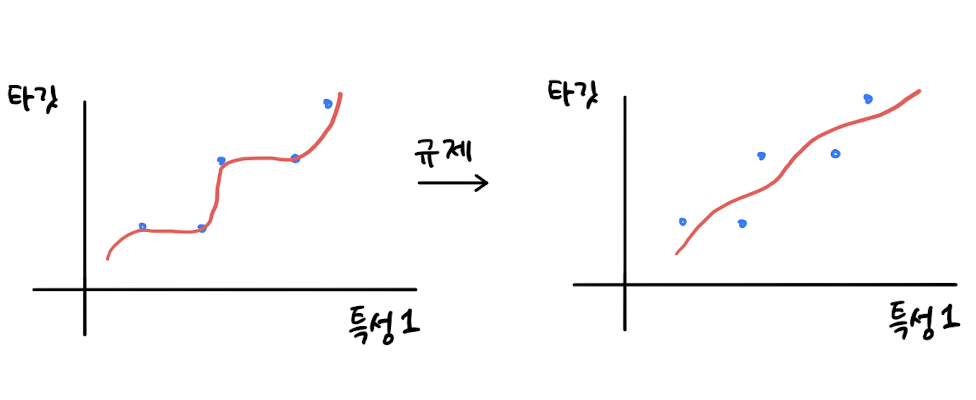

앞서 55개의 특성으로 훈련한 선형 회귀 모델의 계수를 규제하여 훈련 세트의 점수를 낮추고, 대신 테스트 세트의 점수를 높여 보겠습니다.

그 전에, 특성의 스케일을 정규화하기 위해 scikit-learn에서 제공하는 **StandardScaler** class를 사용하여 표준점수로 변환하겠습니다.

In [31]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_poly)

train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

이제 표준점수로 변환한 train_scaled와 test_scaled가 준비되었습니다.

선형 회귀 모델에 regularization을 추가한 모델을 **Ridge**와 **Lasso**라고 부릅니다.

Ridge는 계수를 제곱한 값을 기준으로 규제를 적용하고, Lasso는 계수의 절대값을 기준으로 규제를 적용합니다. 두 알고리즘 모두 계수의 크기를 줄이지만, Lasso는 아예 0으로 만들 수도 있습니다.

### 3.4.1. Ridge (L2 Regularization)

train_scaled 데이터로 Ridge 모델을 훈련해 봅시다.

In [32]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))

0.9896101671037343


테스트 세트에 대한 점수를 확인하겠습니다.

In [33]:
print(ridge.score(test_scaled, test_target))

0.9790693977615386


Ridge와 Lasso 모델을 사용할 때, regularization의 양을 임의로 조절할 수 있습니다. 모델 객체를 만들 때, **alpha** 매개변수로 regularization의 강도를 조절합니다.

적절한 alpha 값을 찾는 한 가지 방법은 alpha 값에 대한 R^2 값의 그래프를 그려 보는 것입니다.

alpha 값을 바꿀 때마다 score() method의 결과를 저장할 리스트를 만듭니다.

In [34]:
import matplotlib.pyplot as plt

train_score = []
test_score = []

alpha 값을 0.001에서 100까지 10배씩 늘려가며 Ridge 회귀 모델을 훈련한 다음, 훈련 세트와 테스트 세트의 점수를 파이썬 리스트에 저장합니다.

In [35]:
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    # 릿지 모델을 만듭니다
    ridge = Ridge(alpha=alpha)
    # 릿지 모델을 훈련합니다
    ridge.fit(train_scaled, train_target)
    # 훈련 점수와 테스트 점수를 저장합니다
    train_score.append(ridge.score(train_scaled, train_target))
    test_score.append(ridge.score(test_scaled, test_target))

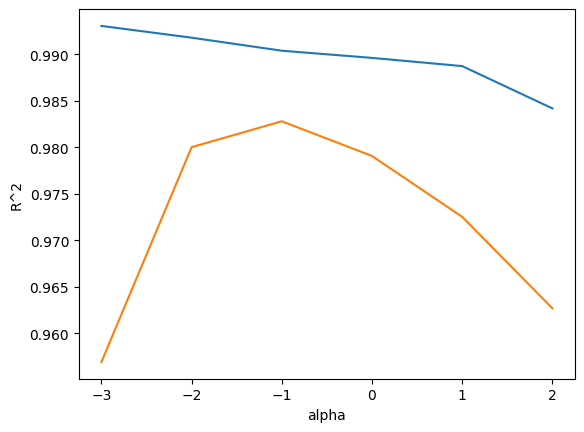

In [36]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

위는 훈련 세트 그래프, 아래는 테스트 세트 그래프입니다.

적절한 alpha 값은 두 그래프가 가장 가깝고 테스트 세트의 점수가 가장 높은 **-1, 즉 0.1**입니다.

alpha 값을 0.1로 하여 최종 모델을 훈련하겠습니다.

In [37]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)

print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570369
0.9827976465386895


### 3.4.2. Lasso (L1 Regularization)

In [38]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))

0.989789897208096


In [39]:
print(lasso.score(test_scaled, test_target))

0.9800593698421884


In [40]:
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    # 라쏘 모델을 만듭니다
    lasso = Lasso(alpha=alpha, max_iter=10000)
    # 라쏘 모델을 훈련합니다
    lasso.fit(train_scaled, train_target)
    # 훈련 점수와 테스트 점수를 저장합니다
    train_score.append(lasso.score(train_scaled, train_target))
    test_score.append(lasso.score(test_scaled, test_target))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e+04, tolerance: 5.183e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e+04, tolerance: 5.183e+02
  model = cd_fast.enet_coordinate_descent(


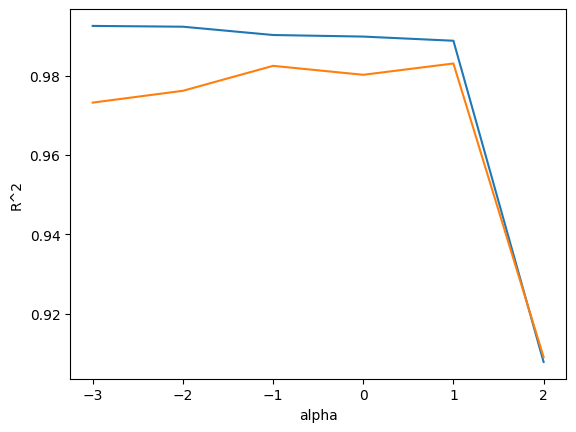

In [41]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

Lasso 모델에서 최적의 alpha 값은 1, 즉 10입니다. 이 값으로 다시 모델을 훈련하겠습니다.

In [42]:
lasso = Lasso(alpha=10)
lasso.fit(train_scaled, train_target)

print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9888067471131867
0.9824470598706695


Lasso 모델은 계수 값을 아예 0으로 만들 수 있다고 했습니다. coef_ 속성을 통해 계수가 0인 것을 헤아려 보겠습니다.

In [43]:
print(np.sum(lasso.coef_ == 0))

41


In [44]:
lasso.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , 12.14852453,
       55.44856399, 42.23100799,  0.        ,  0.        , 13.70596191,
        0.        , 43.2185952 ,  5.7033775 , 47.46254536,  7.42309425,
       11.85823365,  0.        ,  0.        , 13.53038193, 21.22111356,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 18.66993032,  0.        ,  0.        ,  0.        ,
       15.81041778,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       18.14672268,  0.        ,  0.        ,  0.        ,  0.        ,
       15.51272953,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

# 1.Neural Network

## 1.1. Fashion MNIST Dataset

keras.dataset.fasion_mnist 모듈 아래 load_data() 함수는 훈련 데이터와 테스트 데이터를 알아서 나누어 반환합니다.

In [45]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [46]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


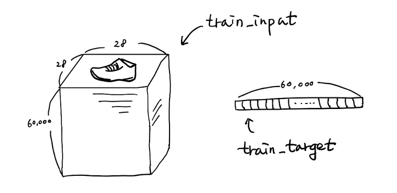

In [47]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


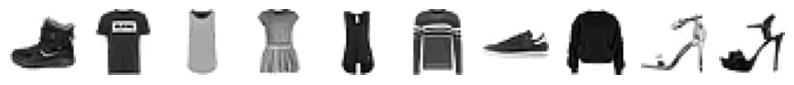

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap='gray_r') # 첫 번째 행에 대해서만 이미지 출력
    axs[i].axis('off')
plt.show()

In [49]:
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


Fashion MNIST에 포함된 10개 label의 의미는 다음과 같습니다.

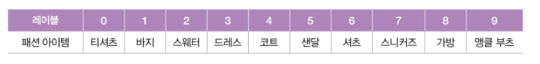

In [50]:
import numpy as np

print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


## 1.2. Artificial Neural Network (ANN)

### 1.2.1. Creating a model with ANN

In [51]:
# Data preprocessing
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

In [52]:
print(train_scaled.shape)

(60000, 784)


In [53]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [54]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [55]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


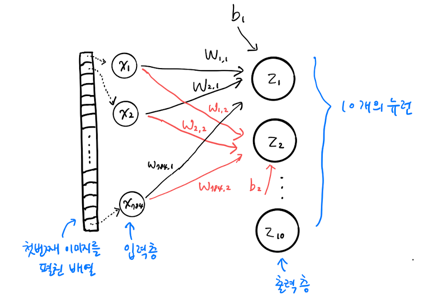

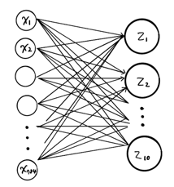

In [56]:
# dense layer 생성
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,))

In [57]:
model = keras.Sequential(dense)

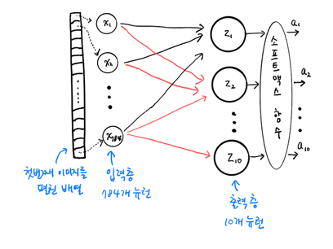

### 1.2.2 Classifying fashion items with ANN

In [58]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

In [59]:
print(train_target[:10])

[7 3 5 8 6 9 3 3 9 9]


In [60]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 10s 3ms/step - loss: 0.6040 - accuracy: 0.7936
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4732 - accuracy: 0.8386
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4499 - accuracy: 0.8475
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4369 - accuracy: 0.8527
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4293 - accuracy: 0.8548


In [61]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.4407 - accuracy: 0.8514


[0.44074398279190063, 0.8514166474342346]

# 2.Deep Neural Network (DNN)

## 2.1. 2 Layers

In [62]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [63]:
from sklearn.model_selection import train_test_split

train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

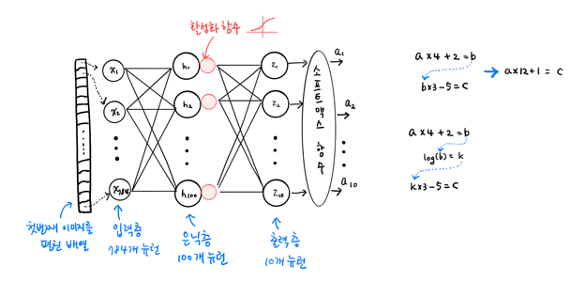

In [64]:
dense1 = keras.layers.Dense(100, activation='sigmoid', input_shape=(784,))
dense2 = keras.layers.Dense(10, activation='softmax')

## 2.2. Create a DNN

In [65]:
model = keras.Sequential([dense1, dense2])

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


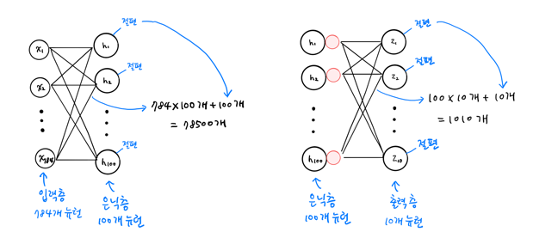

## 2.3. Another way to add layers

In [67]:
model = keras.Sequential([
    keras.layers.Dense(100, activation='sigmoid', input_shape=(784,), name='hidden'),
    keras.layers.Dense(10, activation='softmax', name='output')
], name='패션 MNIST 모델')

In [68]:
model.summary()

Model: "패션 MNIST 모델"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [69]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation='softmax'))

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5707 - accuracy: 0.8048
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4120 - accuracy: 0.8517
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3768 - accuracy: 0.8651
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3542 - accuracy: 0.8722
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3364 - accuracy: 0.8788


## 2.4. ReLU activation funcion

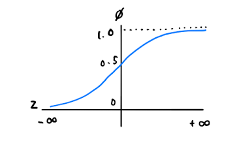

(Sigmoid Funtion)

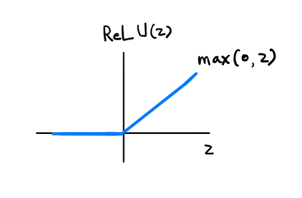

(ReLU Function)

In [72]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [74]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [75]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5297 - accuracy: 0.8135
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3906 - accuracy: 0.8596
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3532 - accuracy: 0.8731
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3319 - accuracy: 0.8820
Epoch 5/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3174 - accuracy: 0.8863


In [76]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3677 - accuracy: 0.8752


[0.3676890730857849, 0.875166654586792]

## 2.5. Optimizer

In [77]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [78]:
sgd = keras.optimizers.SGD(learning_rate=0.1)

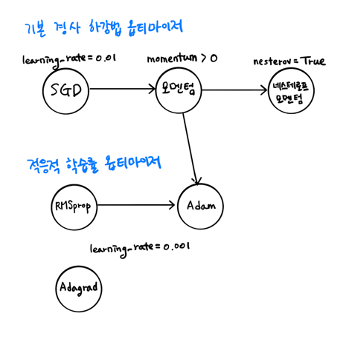

In [79]:
# nesterov momentum optimization
sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)

In [80]:
# Adagrad
adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='sparse_categorical_crossentropy', metrics='accuracy')

In [81]:
# RMSprop
rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics='accuracy')

In [82]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [83]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5279 - accuracy: 0.8162
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3962 - accuracy: 0.8596
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3552 - accuracy: 0.8715
Epoch 4/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3275 - accuracy: 0.8797
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3107 - accuracy: 0.8853


In [84]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3332 - accuracy: 0.8817


[0.33324217796325684, 0.8816666603088379]

# 3.Training a Neural Network Model

## 3.1. Loss Graph

In [85]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [86]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [87]:
model = model_fn()

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               78500     
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=1)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5359 - accuracy: 0.8114
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3912 - accuracy: 0.8597
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3547 - accuracy: 0.8722
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3326 - accuracy: 0.8793
Epoch 5/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3190 - accuracy: 0.8865


In [89]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


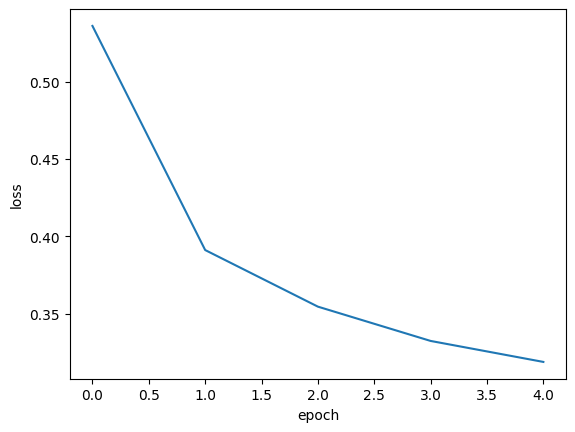

In [90]:
# Loss graph
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

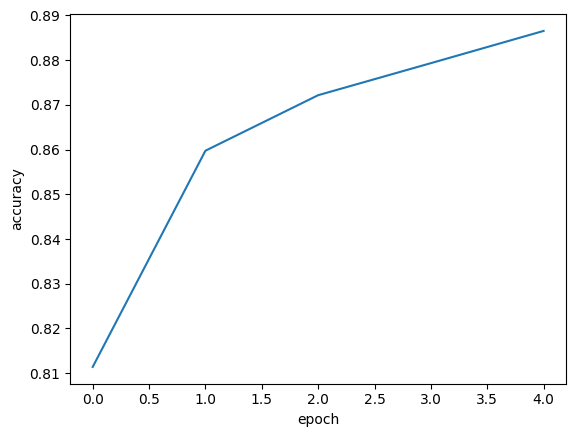

In [91]:
# Accuracy graph
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [92]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

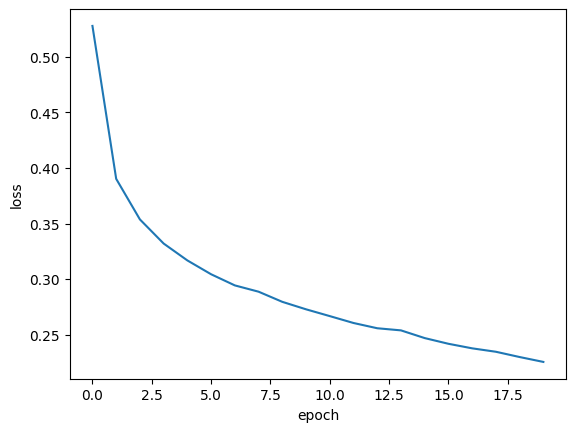

In [93]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 3.2. Validation Loss

In [94]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=1, 
                    validation_data=(val_scaled, val_target))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5338 - accuracy: 0.8098 - val_loss: 0.4149 - val_accuracy: 0.8526
Epoch 2/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3917 - accuracy: 0.8598 - val_loss: 0.4042 - val_accuracy: 0.8571
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3547 - accuracy: 0.8727 - val_loss: 0.3656 - val_accuracy: 0.8700
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3315 - accuracy: 0.8807 - val_loss: 0.4119 - val_accuracy: 0.8660
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3163 - accuracy: 0.8859 - val_loss: 0.3549 - val_accuracy: 0.8742
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3070 - accuracy: 0.8895 - val_loss: 0.3572 - val_accuracy: 0.8792
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2956 - accuracy: 0.8954 - val_loss: 0.3941 - val_accuracy:

In [95]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


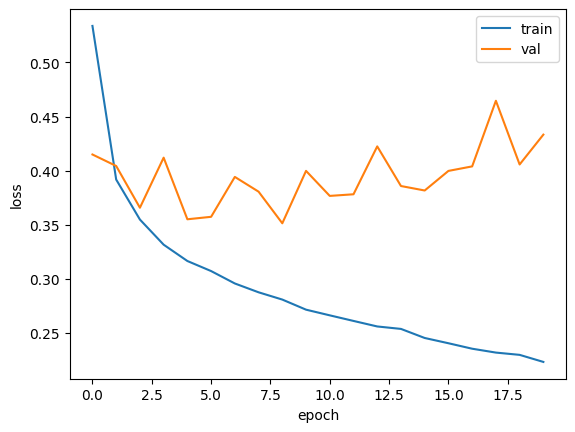

In [96]:
# Training loss + Validation loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [97]:
# Adam optimizer
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=1, 
                    validation_data=(val_scaled, val_target))

Epoch 1/20
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5186 - accuracy: 0.8192 - val_loss: 0.4264 - val_accuracy: 0.8477
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3944 - accuracy: 0.8594 - val_loss: 0.3653 - val_accuracy: 0.8710
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3528 - accuracy: 0.8714 - val_loss: 0.3637 - val_accuracy: 0.8700
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.8802 - val_loss: 0.3481 - val_accuracy: 0.8771
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3082 - accuracy: 0.8862 - val_loss: 0.3540 - val_accuracy: 0.8722
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2917 - accuracy: 0.8921 - val_loss: 0.3227 - val_accuracy: 0.8843
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2784 - accuracy: 0.8984 - val_loss: 0.3458 - val_accuracy:

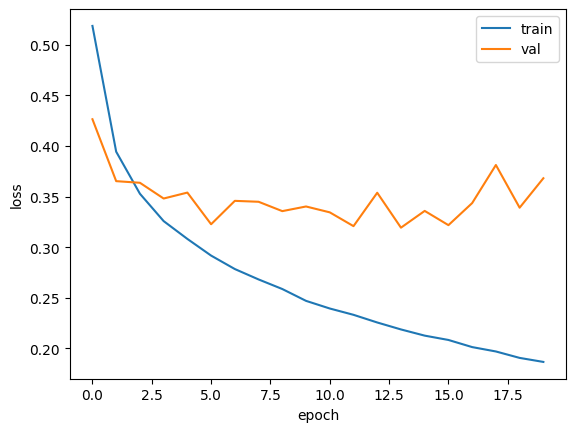

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 3.3. Dropout

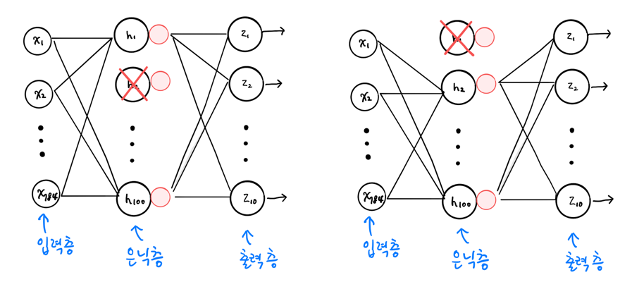

In [99]:
model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=1, 
                    validation_data=(val_scaled, val_target))

Epoch 1/20
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5925 - accuracy: 0.7930 - val_loss: 0.4234 - val_accuracy: 0.8473
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4407 - accuracy: 0.8410 - val_loss: 0.3900 - val_accuracy: 0.8548
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4055 - accuracy: 0.8533 - val_loss: 0.3766 - val_accuracy: 0.8614
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3828 - accuracy: 0.8603 - val_loss: 0.3639 - val_accuracy: 0.8666
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3684 - accuracy: 0.8653 - val_loss: 0.3480 - val_accuracy: 0.8751
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3524 - accuracy: 0.8696 - val_loss: 0.3536 - val_accuracy: 0.8745
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3460 - accuracy: 0.8725 - val_loss: 0.3402 - val_accuracy:

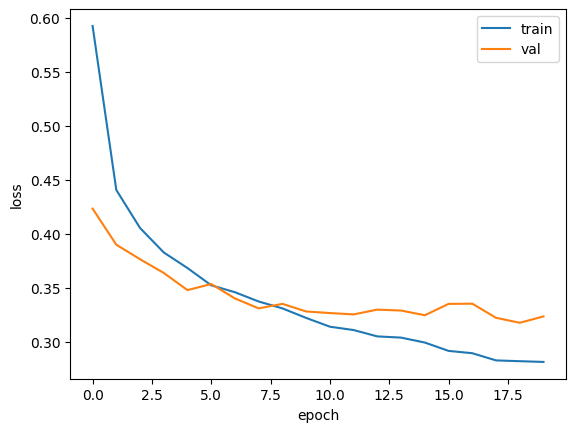

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()